<a href="https://colab.research.google.com/github/hatef-hosseinpour/dental/blob/main/dental_classify_binary_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
from PIL import Image
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
IMAGE_SIZE = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10
NORMALIZATION_MEAN = [0.5, 0.5, 0.5]
NORMALIZATION_STD = [0.5, 0.5, 0.5]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
])


In [5]:
class DentalDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
def load_data(data_dir, label_mapping):
    images = []
    labels = []
    for folder, label in label_mapping.items():
        folder_path = os.path.join(data_dir, folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            if image is not None:
                image = Image.fromarray(image)
                images.append(image)
                labels.append(label)
    return images, labels

In [7]:
def save_best_model(model, val_accuracy, best_accuracy, model_name):
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Dentisrty/data/{model_name}_best.pth")
    return best_accuracy

In [8]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, model_name):
    best_val_accuracy = 0.0
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for idx, (inputs, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {running_loss/len(train_loader.dataset):.4f}')

        # After each epoch, evaluate the model on the validation set
        val_accuracy, _ = evaluate_model(model, val_loader)
        best_val_accuracy = save_best_model(model, val_accuracy, best_val_accuracy, model_name)
        print(f"Validation Accuracy after Epoch {epoch+1}: {val_accuracy:.4f}")

    print(f"Best model for {model_name} saved with validation accuracy: {best_val_accuracy:.4f}")

    # After training, evaluate the model on the test set
    test_accuracy, metrics = evaluate_model(model, test_loader)
    print(f"Test Accuracy for {model_name}")
    print(f'Accuracy: {test_accuracy:.4f}')
    print(f'Confusion Matrix:\n{metrics["confusion_matrix"]}')
    sns.heatmap(metrics["confusion_matrix"], square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()
    print(f'Precision: {metrics["precision"]:.4f}')
    print(f'Recall: {metrics["recall"]:.4f}')
    print(f'F1 Score: {metrics["f1_score"]:.4f}')
    print(f'FPR: {metrics["fpr"]:.4f}')
    print(f'TPR: {metrics["tpr"]:.4f}')
    print(f'AUC: {metrics["auc"]:.4f}')

In [9]:
def calculate_metrics(y_true, y_pred, y_prob):
    # Confusion matrix
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)


    # Calculate precision, recall, and f1-score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Calculate TPR and FPR
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = auc(fpr, tpr)
    # Return all metrics
    return {
        "accuracy" : acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "fpr": fpr[1],
        "tpr": tpr[1],
        "roc_curve": (fpr, tpr),
        "auc": auc_score
    }

In [10]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for idx, (inputs, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())


    accuracy = accuracy_score(all_labels, all_preds)
    metrics = calculate_metrics(all_labels, all_preds, all_probs)



    return accuracy, metrics

In [11]:
def build_pretrained_model(model_name, num_classes):
    if model_name == 'resnet18':
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif model_name == "EfficientNetB4":
        model = models.efficientnet_b4(weights='IMAGENET1K_V1')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model.to(DEVICE)


In [12]:
# Predict function for unseen images
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = data_transforms(image).unsqueeze(0)
    return image

In [13]:
def load_model(model_path, model_class):
    model = model_class()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [14]:
def predict_image(image_path, model_path1, model_path2, model_class):
    image_tensor = preprocess_image(image_path).to(DEVICE)

    # Model 1: Caries detection
    model1 = load_model(model_path1, model_class).to(DEVICE)

    with torch.no_grad():
        output1 = model1(image_tensor)
        prob1 = torch.sigmoid(output1).item()

        if prob1 < 0.5:  # Predicts Caries (class 0)
            print("Caries")
        else:
            # Load and use model2 (to check if it's Amalgam or Normal)
            model2 = load_model(model_path2, model_class).to(DEVICE)
            output2 = model2(image_tensor)
            prob2 = torch.sigmoid(output2).item()

            # Model 2: Amalgam vs Normal
            if prob2 < 0.5:
                print("Amalgam")
            else:
                print("Normal")

Loading data...
Splitting data...
Preparing dataloaders...
Training model: resnet18 for Caries Detection


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Epoch 1/10, Loss: 0.8219


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Validation Accuracy after Epoch 1: 0.7600


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 2/10, Loss: 0.4292


100%|██████████| 1/1 [00:00<00:00, 10.88it/s]


Validation Accuracy after Epoch 2: 0.6000


100%|██████████| 3/3 [00:00<00:00,  9.90it/s]


Epoch 3/10, Loss: 0.5277


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


Validation Accuracy after Epoch 3: 0.7600


100%|██████████| 3/3 [00:00<00:00,  9.74it/s]


Epoch 4/10, Loss: 0.3630


100%|██████████| 1/1 [00:00<00:00, 15.61it/s]


Validation Accuracy after Epoch 4: 0.7600


100%|██████████| 3/3 [00:00<00:00,  7.18it/s]


Epoch 5/10, Loss: 0.4780


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


Validation Accuracy after Epoch 5: 0.7600


100%|██████████| 3/3 [00:00<00:00,  4.38it/s]


Epoch 6/10, Loss: 0.1933


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


Validation Accuracy after Epoch 6: 0.7600


100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


Epoch 7/10, Loss: 0.2383


100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


Validation Accuracy after Epoch 7: 0.7600


100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch 8/10, Loss: 0.3173


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


Validation Accuracy after Epoch 8: 0.7600


100%|██████████| 3/3 [00:00<00:00,  7.03it/s]


Epoch 9/10, Loss: 0.1882


100%|██████████| 1/1 [00:00<00:00,  7.71it/s]


Validation Accuracy after Epoch 9: 0.7600


100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


Epoch 10/10, Loss: 0.1557


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Validation Accuracy after Epoch 10: 0.7600
Best model for resnet18_caries saved with validation accuracy: 0.7600


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Test Accuracy for resnet18_caries
Accuracy: 0.8387
Confusion Matrix:
[[ 0  5]
 [ 0 26]]


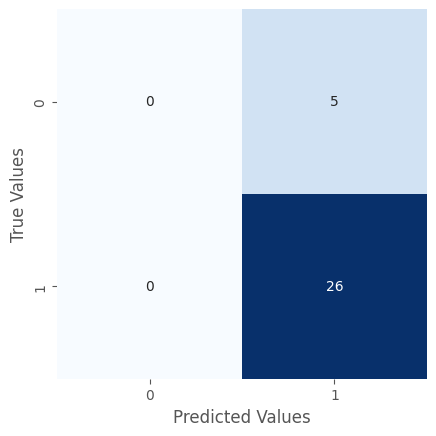

Precision: 0.8387
Recall: 1.0000
F1 Score: 0.9123
FPR: 0.4000
TPR: 0.5769
AUC: 0.6692
Training model: resnet18 for Non-Caries Detection


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


Epoch 1/10, Loss: 0.9610


100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Validation Accuracy after Epoch 1: 0.5714


100%|██████████| 3/3 [00:00<00:00,  6.33it/s]


Epoch 2/10, Loss: 0.6352


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


Validation Accuracy after Epoch 2: 0.6190


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Epoch 3/10, Loss: 0.1949


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


Validation Accuracy after Epoch 3: 0.7143


100%|██████████| 3/3 [00:00<00:00,  9.17it/s]


Epoch 4/10, Loss: 0.2497


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


Validation Accuracy after Epoch 4: 0.8095


100%|██████████| 3/3 [00:00<00:00, 11.12it/s]


Epoch 5/10, Loss: 0.1807


100%|██████████| 1/1 [00:00<00:00, 24.29it/s]


Validation Accuracy after Epoch 5: 0.8095


100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


Epoch 6/10, Loss: 0.2073


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Validation Accuracy after Epoch 6: 0.8095


100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch 7/10, Loss: 0.1568


100%|██████████| 1/1 [00:00<00:00, 25.32it/s]


Validation Accuracy after Epoch 7: 0.8095


100%|██████████| 3/3 [00:00<00:00, 10.01it/s]


Epoch 8/10, Loss: 0.1617


100%|██████████| 1/1 [00:00<00:00, 23.05it/s]


Validation Accuracy after Epoch 8: 0.7619


100%|██████████| 3/3 [00:00<00:00, 10.34it/s]


Epoch 9/10, Loss: 0.1201


100%|██████████| 1/1 [00:00<00:00, 24.99it/s]


Validation Accuracy after Epoch 9: 0.7619


100%|██████████| 3/3 [00:00<00:00, 11.53it/s]


Epoch 10/10, Loss: 0.0966


100%|██████████| 1/1 [00:00<00:00, 30.60it/s]


Validation Accuracy after Epoch 10: 0.7143
Best model for resnet18_non_caries saved with validation accuracy: 0.8095


100%|██████████| 1/1 [00:00<00:00, 24.50it/s]


Test Accuracy for resnet18_non_caries
Accuracy: 0.9259
Confusion Matrix:
[[17  0]
 [ 2  8]]


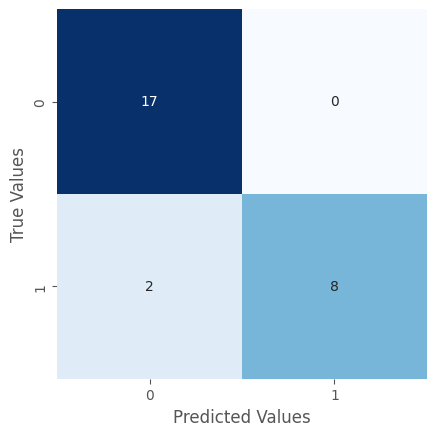

Precision: 1.0000
Recall: 0.8000
F1 Score: 0.8889
FPR: 0.0000
TPR: 0.1000
AUC: 0.9824
Training model: EfficientNetB4 for Caries Detection


100%|██████████| 3/3 [00:00<00:00,  4.78it/s]


Epoch 1/10, Loss: 0.5750


100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


Validation Accuracy after Epoch 1: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Epoch 2/10, Loss: 0.3950


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


Validation Accuracy after Epoch 2: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.83it/s]


Epoch 3/10, Loss: 0.3509


100%|██████████| 1/1 [00:00<00:00, 20.67it/s]


Validation Accuracy after Epoch 3: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.95it/s]


Epoch 4/10, Loss: 0.3302


100%|██████████| 1/1 [00:00<00:00, 19.95it/s]


Validation Accuracy after Epoch 4: 0.7600


100%|██████████| 3/3 [00:00<00:00,  6.06it/s]


Epoch 5/10, Loss: 0.3570


100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


Validation Accuracy after Epoch 5: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.86it/s]


Epoch 6/10, Loss: 0.2637


100%|██████████| 1/1 [00:00<00:00, 20.39it/s]


Validation Accuracy after Epoch 6: 0.7600


100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


Epoch 7/10, Loss: 0.2903


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


Validation Accuracy after Epoch 7: 0.7600


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epoch 8/10, Loss: 0.2455


100%|██████████| 1/1 [00:00<00:00, 12.71it/s]


Validation Accuracy after Epoch 8: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Epoch 9/10, Loss: 0.2637


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


Validation Accuracy after Epoch 9: 0.7600


100%|██████████| 3/3 [00:00<00:00,  4.17it/s]


Epoch 10/10, Loss: 0.2638


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


Validation Accuracy after Epoch 10: 0.7600
Best model for EfficientNetB4_caries saved with validation accuracy: 0.7600


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Test Accuracy for EfficientNetB4_caries
Accuracy: 0.8387
Confusion Matrix:
[[ 0  5]
 [ 0 26]]


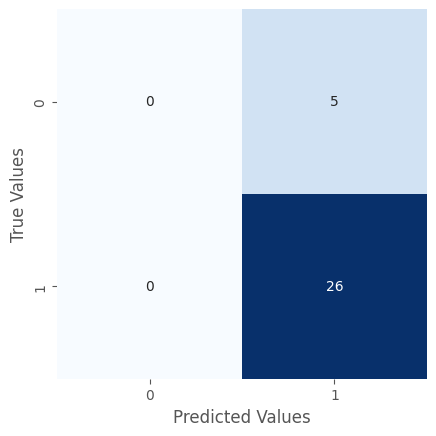

Precision: 0.8387
Recall: 1.0000
F1 Score: 0.9123
FPR: 0.0000
TPR: 0.0385
AUC: 0.7615
Training model: EfficientNetB4 for Non-Caries Detection


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


Epoch 1/10, Loss: 0.7002


100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


Validation Accuracy after Epoch 1: 0.6667


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 2/10, Loss: 0.6712


100%|██████████| 1/1 [00:00<00:00, 21.03it/s]


Validation Accuracy after Epoch 2: 0.7143


100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Epoch 3/10, Loss: 0.6444


100%|██████████| 1/1 [00:00<00:00, 22.14it/s]


Validation Accuracy after Epoch 3: 0.6190


100%|██████████| 3/3 [00:00<00:00,  6.57it/s]


Epoch 4/10, Loss: 0.5894


100%|██████████| 1/1 [00:00<00:00, 21.61it/s]


Validation Accuracy after Epoch 4: 0.7619


100%|██████████| 3/3 [00:00<00:00,  6.31it/s]


Epoch 5/10, Loss: 0.5466


100%|██████████| 1/1 [00:00<00:00, 22.28it/s]


Validation Accuracy after Epoch 5: 0.8095


100%|██████████| 3/3 [00:00<00:00,  6.44it/s]


Epoch 6/10, Loss: 0.5333


100%|██████████| 1/1 [00:00<00:00, 21.69it/s]


Validation Accuracy after Epoch 6: 0.7143


100%|██████████| 3/3 [00:00<00:00,  6.49it/s]


Epoch 7/10, Loss: 0.5449


100%|██████████| 1/1 [00:00<00:00, 21.94it/s]


Validation Accuracy after Epoch 7: 0.6667


100%|██████████| 3/3 [00:00<00:00,  6.58it/s]


Epoch 8/10, Loss: 0.4094


100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


Validation Accuracy after Epoch 8: 0.9048


100%|██████████| 3/3 [00:00<00:00,  6.56it/s]


Epoch 9/10, Loss: 0.3274


100%|██████████| 1/1 [00:00<00:00, 23.47it/s]


Validation Accuracy after Epoch 9: 0.8095


100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


Epoch 10/10, Loss: 0.2651


100%|██████████| 1/1 [00:00<00:00, 22.62it/s]


Validation Accuracy after Epoch 10: 0.8571
Best model for EfficientNetB4_non_caries saved with validation accuracy: 0.9048


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


Test Accuracy for EfficientNetB4_non_caries
Accuracy: 0.8519
Confusion Matrix:
[[15  2]
 [ 2  8]]


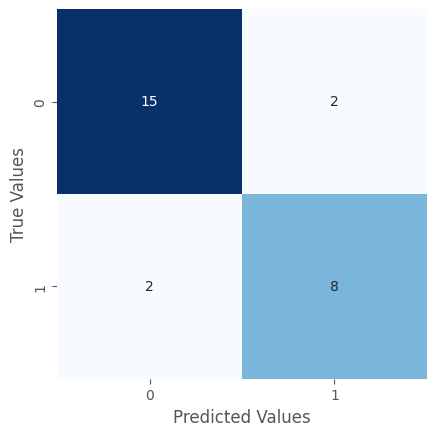

Precision: 0.8000
Recall: 0.8000
F1 Score: 0.8000
FPR: 0.0588
TPR: 0.0000
AUC: 0.8588
Training model: vgg16 for Caries Detection


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


Epoch 1/10, Loss: 2.8754


100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


Validation Accuracy after Epoch 1: 0.7600


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


Epoch 2/10, Loss: 0.4921


100%|██████████| 1/1 [00:00<00:00, 13.20it/s]


Validation Accuracy after Epoch 2: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.32it/s]


Epoch 3/10, Loss: 2.0403


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


Validation Accuracy after Epoch 3: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Epoch 4/10, Loss: 0.5427


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


Validation Accuracy after Epoch 4: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.70it/s]


Epoch 5/10, Loss: 0.5087


100%|██████████| 1/1 [00:00<00:00, 18.92it/s]


Validation Accuracy after Epoch 5: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.96it/s]


Epoch 6/10, Loss: 0.3681


100%|██████████| 1/1 [00:00<00:00, 19.49it/s]


Validation Accuracy after Epoch 6: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Epoch 7/10, Loss: 0.4781


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


Validation Accuracy after Epoch 7: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.39it/s]


Epoch 8/10, Loss: 0.3827


100%|██████████| 1/1 [00:00<00:00, 17.47it/s]


Validation Accuracy after Epoch 8: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.97it/s]


Epoch 9/10, Loss: 0.4167


100%|██████████| 1/1 [00:00<00:00, 17.60it/s]


Validation Accuracy after Epoch 9: 0.7600


100%|██████████| 3/3 [00:00<00:00,  5.85it/s]


Epoch 10/10, Loss: 0.3175


100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


Validation Accuracy after Epoch 10: 0.7600
Best model for vgg16_caries saved with validation accuracy: 0.7600


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


Test Accuracy for vgg16_caries
Accuracy: 0.8387
Confusion Matrix:
[[ 0  5]
 [ 0 26]]


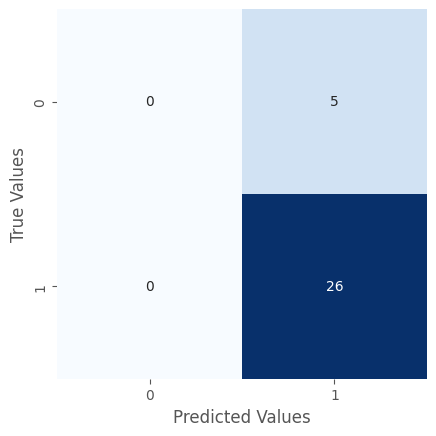

Precision: 0.8387
Recall: 1.0000
F1 Score: 0.9123
FPR: 0.0000
TPR: 0.0385
AUC: 0.4000
Training model: vgg16 for Non-Caries Detection


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


Epoch 1/10, Loss: 3.3430


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


Validation Accuracy after Epoch 1: 0.3333


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Epoch 2/10, Loss: 2.9525


100%|██████████| 1/1 [00:00<00:00, 17.11it/s]


Validation Accuracy after Epoch 2: 0.6667


100%|██████████| 3/3 [00:00<00:00,  5.44it/s]


Epoch 3/10, Loss: 0.7635


100%|██████████| 1/1 [00:00<00:00, 18.65it/s]


Validation Accuracy after Epoch 3: 0.6667


100%|██████████| 3/3 [00:00<00:00,  6.17it/s]


Epoch 4/10, Loss: 0.7248


100%|██████████| 1/1 [00:00<00:00, 19.83it/s]


Validation Accuracy after Epoch 4: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.21it/s]


Epoch 5/10, Loss: 0.7152


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


Validation Accuracy after Epoch 5: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.04it/s]


Epoch 6/10, Loss: 0.7312


100%|██████████| 1/1 [00:00<00:00, 19.36it/s]


Validation Accuracy after Epoch 6: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.19it/s]


Epoch 7/10, Loss: 0.7098


100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


Validation Accuracy after Epoch 7: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.24it/s]


Epoch 8/10, Loss: 0.7038


100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


Validation Accuracy after Epoch 8: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.25it/s]


Epoch 9/10, Loss: 0.6872


100%|██████████| 1/1 [00:00<00:00, 20.78it/s]


Validation Accuracy after Epoch 9: 0.3333


100%|██████████| 3/3 [00:00<00:00,  6.16it/s]


Epoch 10/10, Loss: 0.7040


100%|██████████| 1/1 [00:00<00:00, 20.75it/s]


Validation Accuracy after Epoch 10: 0.6667
Best model for vgg16_non_caries saved with validation accuracy: 0.6667


100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


Test Accuracy for vgg16_non_caries
Accuracy: 0.3704
Confusion Matrix:
[[ 0 17]
 [ 0 10]]


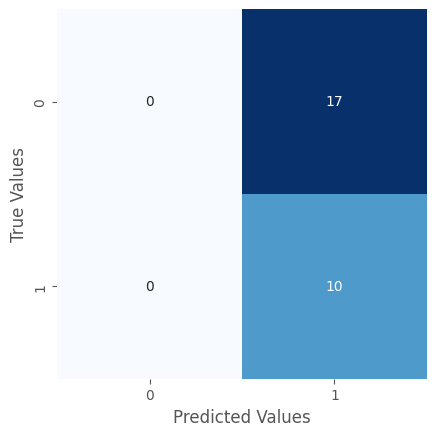

Precision: 0.3704
Recall: 1.0000
F1 Score: 0.5405
FPR: 0.0000
TPR: 0.1000
AUC: 0.8294


In [15]:
if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/Dentisrty/data'  # Update this path

    # Step 1: Define class mappings
    folder_to_label_mapping_caries = {'Caries': 0, 'Amalgam': 1, 'Normal': 1}
    folder_to_label_mapping_non_caries = {'Amalgam': 0, 'Normal': 1}

    # Step 2: Load data for both models
    print("Loading data...")
    images_caries, labels_caries = load_data(data_dir, folder_to_label_mapping_caries)
    images_non_caries, labels_non_caries = load_data(data_dir, folder_to_label_mapping_non_caries)

    # Step 3: Split data into train (80%) and test (20%) sets
    print("Splitting data...")
    X_train_caries, X_test_caries, y_train_caries, y_test_caries = train_test_split(images_caries, labels_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_test_non_caries, y_train_non_caries, y_test_non_caries = train_test_split(images_non_caries, labels_non_caries, test_size=0.2, random_state=42)

    # Step 4: Split train data into train (80%) and validation (20%)
    X_train_caries, X_val_caries, y_train_caries, y_val_caries = train_test_split(X_train_caries, y_train_caries, test_size=0.2, random_state=42)
    X_train_non_caries, X_val_non_caries, y_train_non_caries, y_val_non_caries = train_test_split(X_train_non_caries, y_train_non_caries, test_size=0.2, random_state=42)

    # Step 5: Prepare dataloaders for both models (train, val, and test)
    print("Preparing dataloaders...")
    train_dataset_caries = DentalDataset(X_train_caries, y_train_caries, transform=data_transforms)
    val_dataset_caries = DentalDataset(X_val_caries, y_val_caries, transform=data_transforms)
    test_dataset_caries = DentalDataset(X_test_caries, y_test_caries, transform=data_transforms)

    train_loader_caries = DataLoader(train_dataset_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_caries = DataLoader(val_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_caries = DataLoader(test_dataset_caries, batch_size=BATCH_SIZE, shuffle=False)

    train_dataset_non_caries = DentalDataset(X_train_non_caries, y_train_non_caries, transform=data_transforms)
    val_dataset_non_caries = DentalDataset(X_val_non_caries, y_val_non_caries, transform=data_transforms)
    test_dataset_non_caries = DentalDataset(X_test_non_caries, y_test_non_caries, transform=data_transforms)

    train_loader_non_caries = DataLoader(train_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=True)
    val_loader_non_caries = DataLoader(val_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)
    test_loader_non_caries = DataLoader(test_dataset_non_caries, batch_size=BATCH_SIZE, shuffle=False)

    # Step 6: Train multiple models for both Caries and Non-Caries detection
    models_to_test = ['resnet18', "EfficientNetB4", 'vgg16']

    for model_name in models_to_test:
        # Caries Detection Model (2 classes: Caries and Non-Caries)
        model_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Caries Detection")
        train_model(model_caries, train_loader_caries, val_loader_caries, test_loader_caries, criterion, optimizer, model_name + "_caries")
        del model_caries
        torch.cuda.empty_cache()
        gc.collect()

        # Non-Caries Detection Model (2 classes: Amalgam and Normal)
        model_non_caries = build_pretrained_model(model_name, 2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_non_caries.parameters(), lr=LEARNING_RATE)
        print(f"Training model: {model_name} for Non-Caries Detection")
        train_model(model_non_caries, train_loader_non_caries, val_loader_non_caries, test_loader_non_caries, criterion, optimizer, model_name + "_non_caries")
        del model_non_caries
        torch.cuda.empty_cache()
        gc.collect()